# Demo de implementación de un algoritmo de Programación Genética para obtener una fórmula matemática que se aproxime al comportamiento de un conjunto de datos
Ejemplo adaptado de https://deap.readthedocs.io/en/master/examples/gp_symbreg.html
Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

0) Preparar el ambiente:

In [1]:
#@title

# instala paquetes DEAP
!pip install deap

# instala paquetes gráficos
!apt-get install -y graphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
libgraphviz-dev is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


1) Importar librerías:

In [2]:
#@title
import random
import numpy as np

import operator
import math

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import matplotlib.pyplot as plt
import pygraphviz as pgv
from IPython.display import display
import tempfile
from PIL import Image
#import networkx as nx

print("\nLibrerías importadas")


Librerías importadas


2) Definir los Datos (ENTRADA y SALIDA) para que intente aproximar la fórmula correspondiente:

In [3]:
#@title DATOS DE FUNCIÓN A APROXIMAR
# Para este ejemplo se trata de aproximar:  x al cubo más 1
ENTRADA = range(100)
SALIDA = []
for x in ENTRADA:
  SALIDA.append( x**2 + x + 1 )

print("Entradas: ", list(ENTRADA))
print("Salidas: ", SALIDA)

Entradas:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Salidas:  [1, 3, 7, 13, 21, 31, 43, 57, 73, 91, 111, 133, 157, 183, 211, 241, 273, 307, 343, 381, 421, 463, 507, 553, 601, 651, 703, 757, 813, 871, 931, 993, 1057, 1123, 1191, 1261, 1333, 1407, 1483, 1561, 1641, 1723, 1807, 1893, 1981, 2071, 2163, 2257, 2353, 2451, 2551, 2653, 2757, 2863, 2971, 3081, 3193, 3307, 3423, 3541, 3661, 3783, 3907, 4033, 4161, 4291, 4423, 4557, 4693, 4831, 4971, 5113, 5257, 5403, 5551, 5701, 5853, 6007, 6163, 6321, 6481, 6643, 6807, 6973, 7141, 7311, 7483, 7657, 7833, 8011, 8191, 8373, 8557, 8743, 8931, 9121, 9313, 9507, 9703, 9901]


3) Inicializar objetos de DEAP para utilizar y especificar Primitivas, Estructura del Cromosoma + Función de Aptitud y Operadores Genéticos:

In [4]:
#@title Inicializar valores de la librería DEAP

## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

## PRIMITIVAS QUE SE VAN A UTILIZAR 
## PARA GENERAR EL ÁRBOL DE LA FÓRMULA MATEMÁTICA
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("ca"+str(random.randint(0,100)), lambda: random.randint(-99,99))
pset.addEphemeralConstant("cb"+str(random.randint(0,100)), lambda: random.randint(-99,99))

pset.renameArguments(ARG0='x')

print("\nPrimitivas definidas")

# indica que es la función de aptitud es para minimizar el error
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def calculaError(individual):
    # Transforma la expresión del árbol en una función que se puede ejecutar
    try:
      func = toolbox.compile(expr=individual)
    except MemoryError:
      # si tira error por BLOAT devuelve un error muy grande para descartarlo
      return 9999

    # calcula la diferencia entre lo que devuelve la función y el valor Y
    sqerrors = ((func(x) - y)**2 for x, y in zip(ENTRADA, SALIDA))
    # calcula el promedio del error total
    return math.fsum(sqerrors) / len(ENTRADA),

toolbox.register("evaluate", calculaError)

print("\nFunción de Aptitud y Cromosoma definidos")


Primitivas definidas

Función de Aptitud y Cromosoma definidos


In [5]:
#@title  OPERADORES GENÉTICOS
## (ver lista completa en https://deap.readthedocs.io/en/master/api/tools.html#operators )

tipo_seleccion = 'Torneo' #@param ["Torneo", "Ranking"]

# Registrar tipo de Selección a aplicar con sus parámetros
if tipo_seleccion == 'Torneo':
  toolbox.register("select", tools.selTournament, tournsize=2)
elif tipo_seleccion == 'Ranking':
  toolbox.register("select", tools.selBest)
elif tipo_seleccion == 'Ruleta':
  toolbox.register("select", tools.selRoulette)
elif tipo_seleccion == 'Estocastica':
  toolbox.register("select", tools.selStochasticUniversalSampling)
else:
  toolbox.register("select", tools.selRandom)

# Registrar tipo de Cruzamiento a aplicar con sus parámetros
toolbox.register("mate", gp.cxOnePoint)

# Registrar tipo de Mutación a aplicar con sus parámetros
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# define parámetros adicionales para evitar el BLOAT
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=15))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))

print("\nOperadores Genéticos definidos")


Operadores Genéticos definidos


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [6]:
### Parámetros de la Corrida

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 100 #@param {type:"integer"}

# Indica que finaliza corrida cuando se alcance una  Diferencia Máxima (opcional)
FINALIZA_CORRIDA_POR_MAX_APTITUD = True #@param {type:"boolean"}
FINALIZA_CORRIDA_VAL_MAX_APTITUD = 0.1 #@param {type:"slider", min:0, max:10, step:0.1}

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 30 #@param {type:"slider", min:1, max:100, step:1}

# Probabilidad del Cruzamiento (en AG 1 = 100%)
PROBAB_CRUZAMIENTO = 1 #@param {type:"slider", min:0, max:1, step:0.05}

# Probabilidad del Mutación 
PROBAB_MUTACION = 0.2  #@param {type:"slider", min:0, max:1, step:0.05}

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True #@param {type:"boolean"}

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


In [7]:
#@title EJECUCIÓN DE LA CORRIDA


## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra, mejorMax = True):
    
    global mejorIndCorrida
    global ciclosMaxAptitud
    global ciclosPromAptitud
    global ciclosMinAptitud

    if len(indivPobla) == 0:
      return None, 0, 0, 0 

    auxMax = None
    auxMin = None
    auxSum = 0
    auxBestInd = None
    auxBestIndApt = None
    
    for ind in indivPobla:

        apt = round(ind.fitness.values[0], 2)
        auxSum = auxSum + apt

        if (auxMax == None) or (apt > auxMax):
            auxMax = apt
            if mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt

        if (auxMin == None) or (apt < auxMin):
            auxMin = apt
            if not mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt

    auxProm = round(auxSum / len(indivPobla),2)

    ciclosMinIndiv.append( auxBestInd )
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )

    if muestra:          
        print("\n-- Ciclo  %i --" % ciclo)
        print(" Mejor Individuo:", auxBestInd, " {", auxBestIndApt, "}")
        print("   Max: ", auxMax, " / Promedio: ", auxProm, " / Min: ", auxMin)

    return auxBestInd, auxMax, auxProm, auxMin


# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)

# Asigna el valor de aptitud a los individuos de la población inicial
fitnesses = list(map(toolbox.evaluate, indivPobla))
for ind, fit in zip(indivPobla, fitnesses):
    ind.fitness.values = fit

# vectores auxiliares 
ciclo = 1    
ciclosMinIndiv = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []

# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS, mejorMax=False)

        # criterio de paro
while (ciclo < CANT_CICLOS) and (not(FINALIZA_CORRIDA_POR_MAX_APTITUD) or (auxMin > FINALIZA_CORRIDA_VAL_MAX_APTITUD)):

    # Realiza la Selección
    indivSelecc = toolbox.select(indivPobla, len(indivPobla))

    # Inicializa a los hijos clonando a los seleccionados
    indivHijos = list(map(toolbox.clone, indivSelecc))
    
    # Realiza el Cruzamiento
    for hijo1, hijo2 in zip(indivHijos[::2], indivHijos[1::2]):
        if random.random() < PROBAB_CRUZAMIENTO:
            hijo1, hijo2 = toolbox.mate(hijo1, hijo2)
            #toolbox.mate(hijo1, hijo2)
            del hijo1.fitness.values
            del hijo2.fitness.values
            
    # Realiza la Mutación
    for mutant in indivHijos:
        if random.random() < PROBAB_MUTACION:
            toolbox.mutate(mutant)
            del mutant.fitness.values
              
    # Evalua a los individuos que salen de la Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivHijos if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    # Reemplaza la población actual con los hijos
    indivPobla[:] = indivHijos
    
    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS, mejorMax=False)

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --" % ciclo )

mejorCiclo = np.argmin( ciclosMinAptitud )

print("\n== Mejor Individuo de la Corrida:", ciclosMinIndiv[mejorCiclo], " { ", ciclosMinAptitud[mejorCiclo], " } ==")


-- Ciclo  0 --
 Mejor Individuo: add(mul(x, x), protectedDiv(x, x))  { 3283.5 }
   Max:  83918021.8  / Promedio:  21537643.18  / Min:  3283.5

-- Ciclo  1 --
 Mejor Individuo: add(mul(x, x), protectedDiv(mul(x, x), x))  { 0.99 }
   Max:  8013867424517.8  / Promedio:  269033552655.5  / Min:  0.99

-- Ciclo  2 --
 Mejor Individuo: add(mul(x, x), protectedDiv(mul(x, x), 35))  { 5115.53 }
   Max:  9336948971.8  / Promedio:  328971513.45  / Min:  5115.53

-- Ciclo  3 --
 Mejor Individuo: add(-48, mul(35, x))  { 6796609.3 }
   Max:  1470876047.22  / Promedio:  69919374.13  / Min:  6796609.3

-- Ciclo  4 --
 Mejor Individuo: add(sub(85, mul(44, -61)), x)  { 8987701.3 }
   Max:  8646087454261.3  / Promedio:  288221328443.77  / Min:  8987701.3

-- Ciclo  5 --
 Mejor Individuo: add(sub(85, mul(x, -61)), x)  { 1790890.8 }
   Max:  20502854.52  / Promedio:  17516082.14  / Min:  1790890.8

-- Ciclo  6 --
 Mejor Individuo: add(sub(85, mul(44, -61)), x)  { 8987701.3 }
   Max:  194274132741.3  / Prom


> Mejor Individuo de la Corrida:


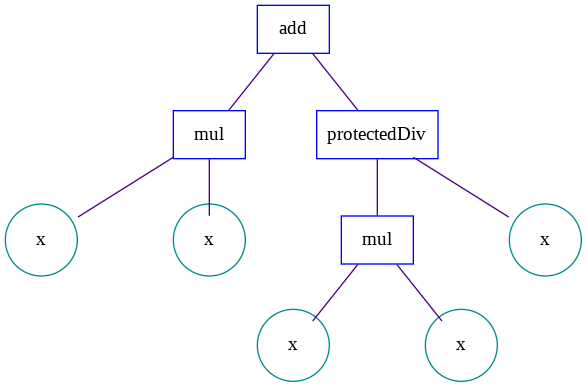



add(mul(x, x), protectedDiv(mul(x, x), x))


  x 		 yREAL 		 yCALC 		 ERROR
--------------------------------------------------------
   0 		 1 		 1 		 0
   1 		 3 		 2.0 		 1.0
   2 		 7 		 6.0 		 1.0
   3 		 13 		 12.0 		 1.0
   4 		 21 		 20.0 		 1.0
   5 		 31 		 30.0 		 1.0
   6 		 43 		 42.0 		 1.0
   7 		 57 		 56.0 		 1.0
   8 		 73 		 72.0 		 1.0
   9 		 91 		 90.0 		 1.0
   10 		 111 		 110.0 		 1.0
   11 		 133 		 132.0 		 1.0
   12 		 157 		 156.0 		 1.0
   13 		 183 		 182.0 		 1.0
   14 		 211 		 210.0 		 1.0
   15 		 241 		 240.0 		 1.0
   16 		 273 		 272.0 		 1.0
   17 		 307 		 306.0 		 1.0
   18 		 343 		 342.0 		 1.0
   19 		 381 		 380.0 		 1.0
   20 		 421 		 420.0 		 1.0
   21 		 463 		 462.0 		 1.0
   22 		 507 		 506.0 		 1.0
   23 		 553 		 552.0 		 1.0
   24 		 601 		 600.0 		 1.0
   25 		 651 		 650.0 		 1.0
   26 		 703 		 702.0 		 1.0
   27 		 757 		 756.0 		 1.0
   28 		 813 		 812.0 		 1.0
   29 		 871 		 870.0 		 1.0
   30 		 931 		 930.0 		 1.0
   31 

In [8]:
#@title MOSTRAR GRAFICO DE LA EXPRESIÓN 
## CORRESPONDIENTE AL MEJOR INDIVIDUO 
print("\n> Mejor Individuo de la Corrida:")
nodes, edges, labels = gp.graph( ciclosMinIndiv[mejorCiclo] )

g = pgv.AGraph(overlap=False, splines='polyline') # indica tipo de uniones
g.graph_attr['label']='' # título
g.graph_attr['ranksep']='0.6' # separación entre niveles 
g.graph_attr['nodesep']='1' # separación en el mismo nivel

g.graph_attr['label']=''
g.node_attr['shape']='box'
g.node_attr['color']='blue'
g.edge_attr['color']='indigo'
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]
    if labels[i]=='x':
      n.attr['shape']='circle'
      n.attr['color']='cyan4'
    elif str(labels[i]).isnumeric():
      n.attr['shape']='circle'
      n.attr['color']='dimgray'


# genera una imagen temporal con el árbol y la muestra
auxFile = tempfile.NamedTemporaryFile(suffix=".png")
g.draw(auxFile.name,format="png")
display(Image.open(auxFile.name))

# Aplica y muesta el resultado
print("\n")
print( ciclosMinIndiv[mejorCiclo] )
func = toolbox.compile(expr=ciclosMinIndiv[mejorCiclo])
print("\n")
print("  x \t\t yREAL \t\t yCALC \t\t ERROR")
print("--------------------------------------------------------")
error = 0.0
for x, y in zip(ENTRADA, SALIDA):
  calc = func(x)
  error = error + abs(y-calc)
  print("  ", x, "\t\t", round(y, 3), "\t\t", round(calc, 3), "\t\t", round((y-calc), 3) )

print("\n== Error absoluto total: ", round(error,3))


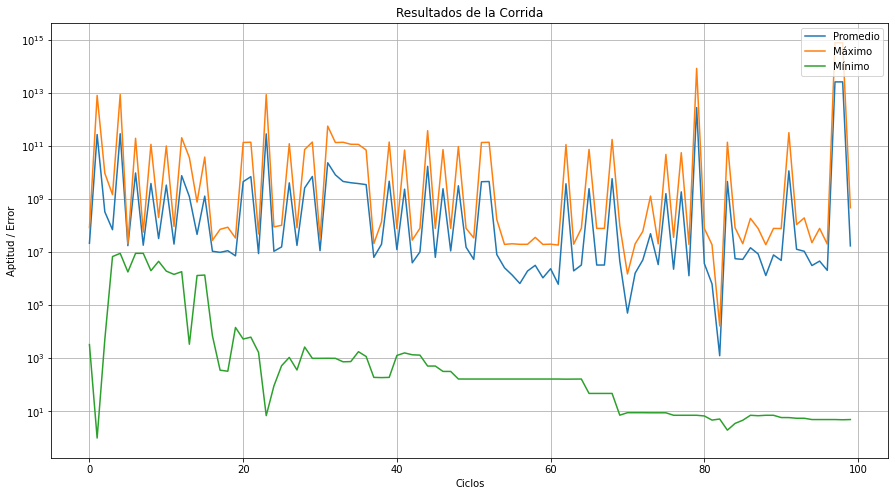

In [9]:
#@title MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8)) 
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMaxAptitud)
plt.plot(ciclosMinAptitud)
plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud / Error')
plt.yscale('log')
plt.legend(['Promedio', 'Máximo', 'Mínimo'], loc='upper right')
plt.grid(True)

plt.show()